In [ ]:
# importing libraries
!pip install pafy 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import cv2
import math
import random
import numpy as np
import tensorflow as tf
import datetime as dt
from collections import deque
import matplotlib.pyplot as plt

In [ ]:
from moviepy.editor import *
%matplotlib inline

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [ ]:
seed_constant=27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [ ]:
# visualize and download data
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar
!unrar x UCF50.rar

Streaming output truncated to the last 5000 lines.
Extracting  UCF50/HorseRace/v_HorseRace_g16_c03.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g16_c04.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g16_c05.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c01.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c02.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c03.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c04.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c05.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g18_c01.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g18_c02.avi                       23%  OK 
Extracting  UCF50/HorseRace/v

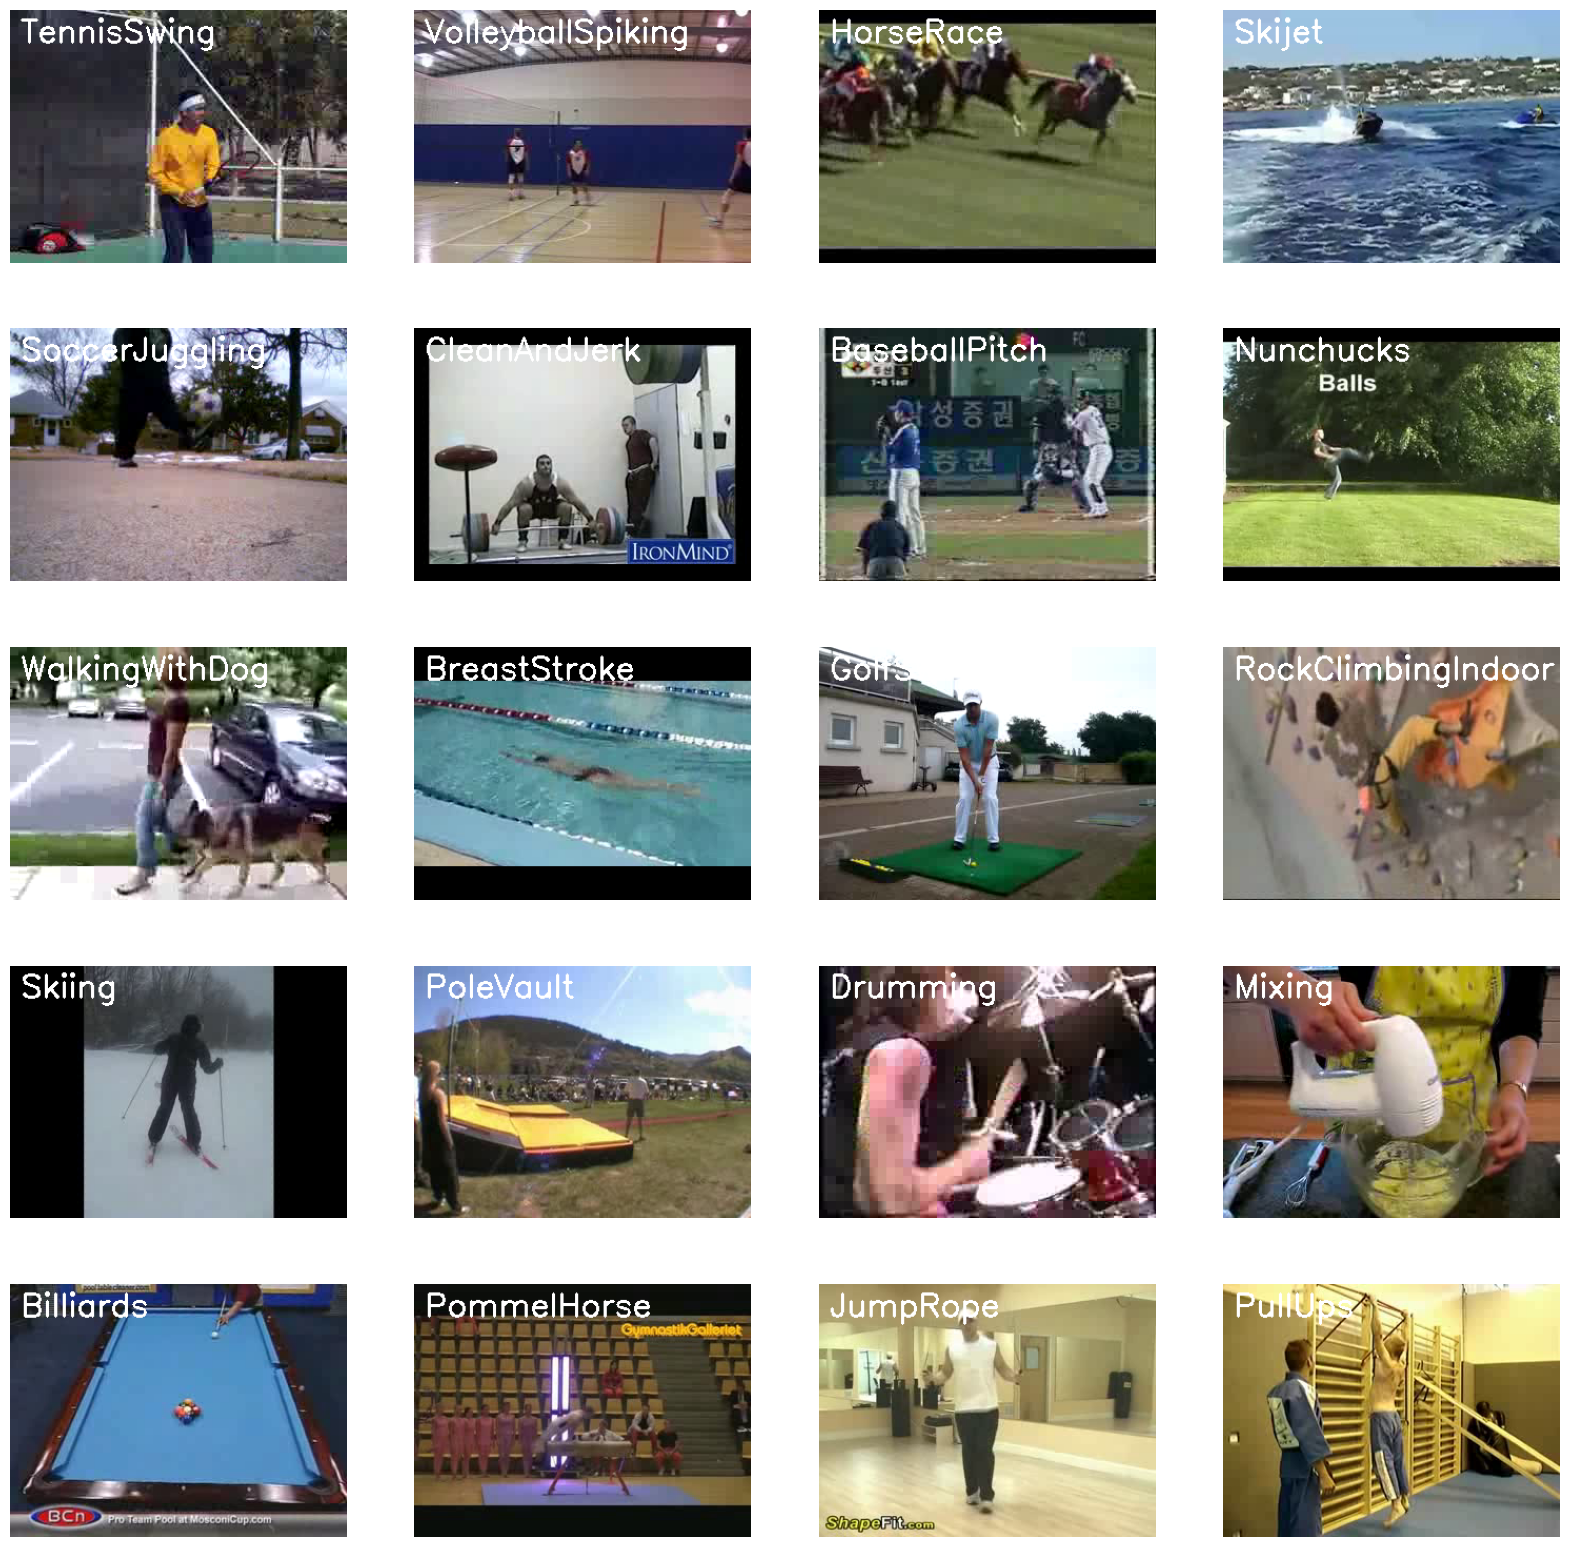

In [ ]:
# displaying the first frame out of random 20 activities
plt.figure(figsize=(20,20))
all_classes_names=os.listdir('UCF50')
random_range=random.sample(range(len(all_classes_names)), 20)

for counter, random_index in enumerate(random_range, 1):
  selected_class_name=all_classes_names[random_index]
  video_files_names_list=os.listdir(f'UCF50/{selected_class_name}')
  selected_video_file_name=random.choice(video_files_names_list)
  video_reader=cv2.VideoCapture(f'UCF50/{selected_class_name}/{selected_video_file_name}')
  _, bgr_frame=video_reader.read()
  video_reader.release()
  rgb_frame=cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
  cv2.putText(rgb_frame, selected_class_name, (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
  plt.subplot(5,4,counter);plt.imshow(rgb_frame);plt.axis('off')

In [ ]:
# data preprocessing
image_height, image_width=64,64
sequence_length=20
dataset_dir='UCF50'
classes_list=['WalkingWithDog', 'TaiChi', 'Swing', 'HorseRace']

In [ ]:
def frames_extraction(video_path):
  frames_list=[]
  video_reader=cv2.VideoCapture(video_path)
  video_frames_count=int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
  skip_frames_window=max(int(video_frames_count/sequence_length), 1)
  for frame_counter in range(sequence_length):
    video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter*skip_frames_window)
    success, frame=video_reader.read()
    if not success:
      break
    resized_frame=cv2.resize(frame, (image_height, image_width))
    normalized_frame=resized_frame/255
    frames_list.append(normalized_frame)
  video_reader.release()
  return frames_list  

In [ ]:
# create dataset
def create_dataset():
  features=[]
  labels=[]
  video_files_paths=[]
  for class_index, class_name in enumerate(classes_list):
    print(f'Extracting data of class: {class_name}')
    files_list=os.listdir(os.path.join(dataset_dir, class_name))
    for file_name in files_list:
      video_file_path=os.path.join(dataset_dir, class_name, file_name)
      frames=frames_extraction(video_file_path)
      if len(frames)==sequence_length:
        features.append(frames)
        labels.append(class_index)
        video_files_paths.append(video_file_path)
  features=np.asarray(features)
  labels=np.array(labels)
  return features, labels, video_files_paths

In [ ]:
features, labels, video_files_paths=create_dataset()

Extracting data of class: WalkingWithDog
Extracting data of class: TaiChi
Extracting data of class: Swing
Extracting data of class: HorseRace


In [ ]:
# categories to one-hot encoded labels
one_hot_encoded_labels=to_categorical(labels)

In [ ]:
features_train, features_test, labels_train, labels_test=train_test_split(features, one_hot_encoded_labels, test_size=0.25, shuffle=True, random_state=seed_constant)

In [ ]:
# implement convLSTM
def create_convlstm_model():
  model=Sequential()
  model.add(ConvLSTM2D(filters=4, kernel_size=(3, 3), activation='tanh', input_shape=(sequence_length, image_height, image_width, 3), data_format='channels_last', recurrent_dropout=0.2, return_sequences=True))
  model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))
  model.add(ConvLSTM2D(filters=8, kernel_size=(3, 3), activation='tanh', data_format='channels_last', recurrent_dropout=0.2, return_sequences=True))
  model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))
  model.add(ConvLSTM2D(filters=14, kernel_size=(3, 3), activation='tanh', data_format='channels_last', recurrent_dropout=0.2, return_sequences=True))
  model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))
  model.add(ConvLSTM2D(filters=16, kernel_size=(3, 3), activation='tanh', data_format='channels_last', recurrent_dropout=0.2, return_sequences=True))
  model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
  model.add(Flatten())
  model.add(Dense(len(classes_list), activation='softmax'))
  model.summary()
  return model

In [ ]:
convlstm_model=create_convlstm_model()
print('Created')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 20, 62, 62, 4)     1024      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 20, 31, 31, 4)    0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 20, 31, 31, 4)    0         
 ibuted)                                                         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 20, 29, 29, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 20, 15, 15, 8)    0         
 3D)                                                             
                                                        

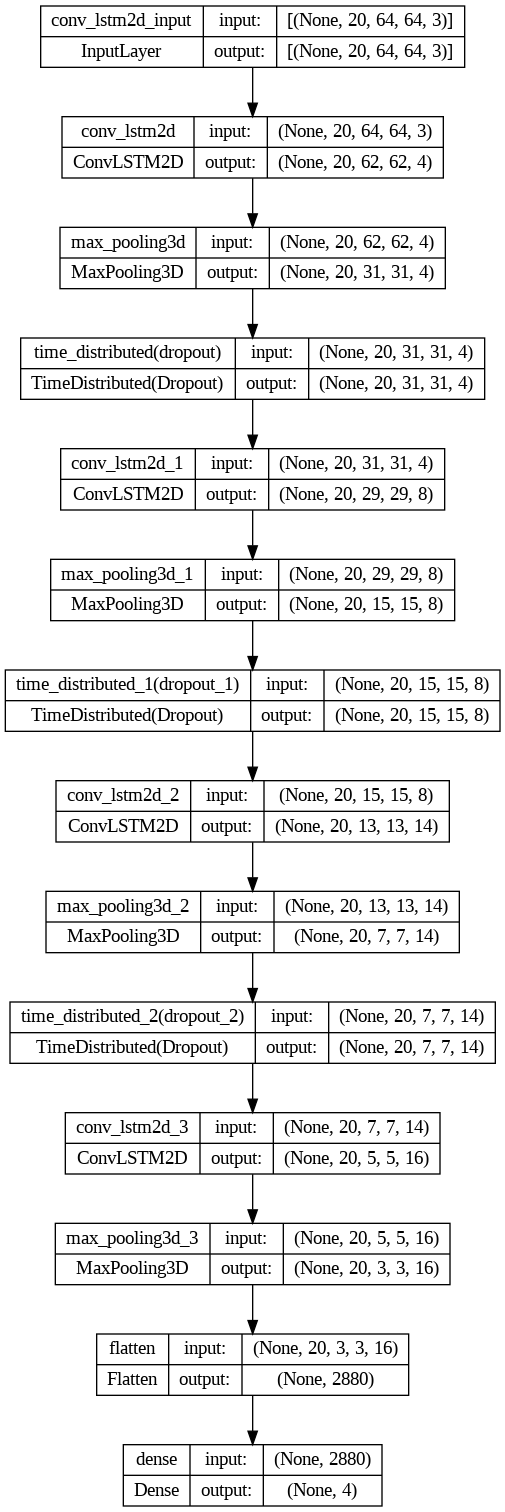

In [ ]:
plot_model(convlstm_model, to_file='convlstm_structure.png', show_shapes=True, show_layer_names=True)

In [ ]:
early_stopping_callback=EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)
convlstm_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
convlstm_model_hist=convlstm_model.fit(x=features_train, y=labels_train, epochs=50, batch_size=4, shuffle=True, validation_split=0.2, callbacks=[early_stopping_callback])

Epoch 1/50
73/73 [==============================] - 166s 2s/step - loss: 1.3812 - accuracy: 0.2671 - val_loss: 1.3757 - val_accuracy: 0.2329
Epoch 2/50
73/73 [==============================] - 156s 2s/step - loss: 1.3507 - accuracy: 0.3493 - val_loss: 1.3506 - val_accuracy: 0.4795
Epoch 3/50
73/73 [==============================] - 166s 2s/step - loss: 1.3257 - accuracy: 0.4281 - val_loss: 1.2907 - val_accuracy: 0.4110
Epoch 4/50
73/73 [==============================] - 165s 2s/step - loss: 1.2031 - accuracy: 0.4863 - val_loss: 1.1852 - val_accuracy: 0.3425
Epoch 5/50
73/73 [==============================] - 157s 2s/step - loss: 0.9006 - accuracy: 0.6404 - val_loss: 0.7796 - val_accuracy: 0.7123
Epoch 6/50
73/73 [==============================] - 163s 2s/step - loss: 0.7071 - accuracy: 0.7021 - val_loss: 0.6716 - val_accuracy: 0.7397
Epoch 7/50
73/73 [==============================] - 165s 2s/step - loss: 0.5420 - accuracy: 0.7842 - val_loss: 0.8262 - val_accuracy: 0.7123
Epoch 8/50
73

In [ ]:
model_evaluation_history=convlstm_model.evaluate(features_test, labels_test)

4/4 [==============================] - 18s 5s/step - loss: 0.4790 - accuracy: 0.8361


In [ ]:
# accuracy and loss
model_evaluation_loss, model_evaluation_accuracy=model_evaluation_history
date_time_format='%Y_%m_%d_%H_%M_%S'
current_date_time_dt=dt.datetime.now()
current_date_time_string=dt.datetime.strftime(current_date_time_dt, date_time_format)
model_file_name=f'convlstm_model__Date_Time{current_date_time_string}__Loss{model_evaluation_loss}__Accuracy_{model_evaluation_accuracy}.h5'
convlstm_model.save(model_file_name)

In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
  metric_value_1=model_training_history.history[metric_name_1]
  metric_value_2=model_training_history.history[metric_name_2]
  epochs=range(len(metric_value_1))
  plt.plot(epochs, metric_value_1, 'blue', label=metric_name_1)
  plt.plot(epochs, metric_value_2, 'red', label=metric_name_2)
  plt.title(str(plot_name))
  plt.legend()

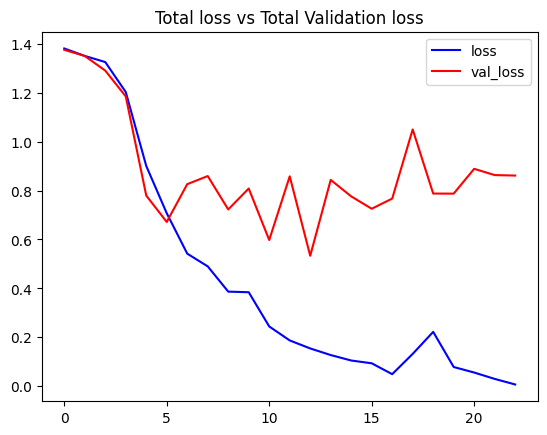

In [ ]:
plot_metric(convlstm_model_hist, 'loss', 'val_loss', 'Total loss vs Total Validation loss')

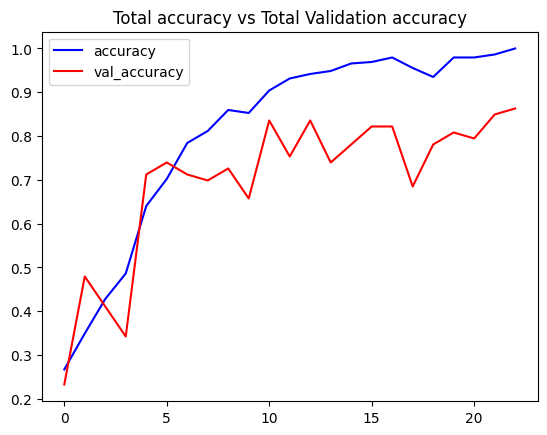

In [ ]:
plot_metric(convlstm_model_hist, 'accuracy', 'val_accuracy', 'Total accuracy vs Total Validation accuracy')

In [ ]:
# implement lrcn approach
def create_lrcn_model():
  model=Sequential()
  model.add(TimeDistributed(Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(sequence_length, image_height, image_width, 3))))
  model.add(TimeDistributed(MaxPooling2D(4,4)))
  model.add(TimeDistributed(Dropout(0.25)))
  model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same')))
  model.add(TimeDistributed(MaxPooling2D(4,4)))
  model.add(TimeDistributed(Dropout(0.25)))
  model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same')))
  model.add(TimeDistributed(MaxPooling2D(2,2)))
  model.add(TimeDistributed(Dropout(0.25)))
  model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same')))
  model.add(TimeDistributed(MaxPooling2D(2,2)))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(32))
  model.add(Dense(len(classes_list), activation='softmax'))
  model.build(input_shape=(None, sequence_length, image_height, image_width, 3))
  model.summary()
  return model

In [ ]:
lrcn_model=create_lrcn_model()
print('Created')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDis  (None, 20, 64, 64, 16)   448       
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 20, 16, 16, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 20, 16, 16, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 20, 16, 16, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 20, 4, 4, 32)    

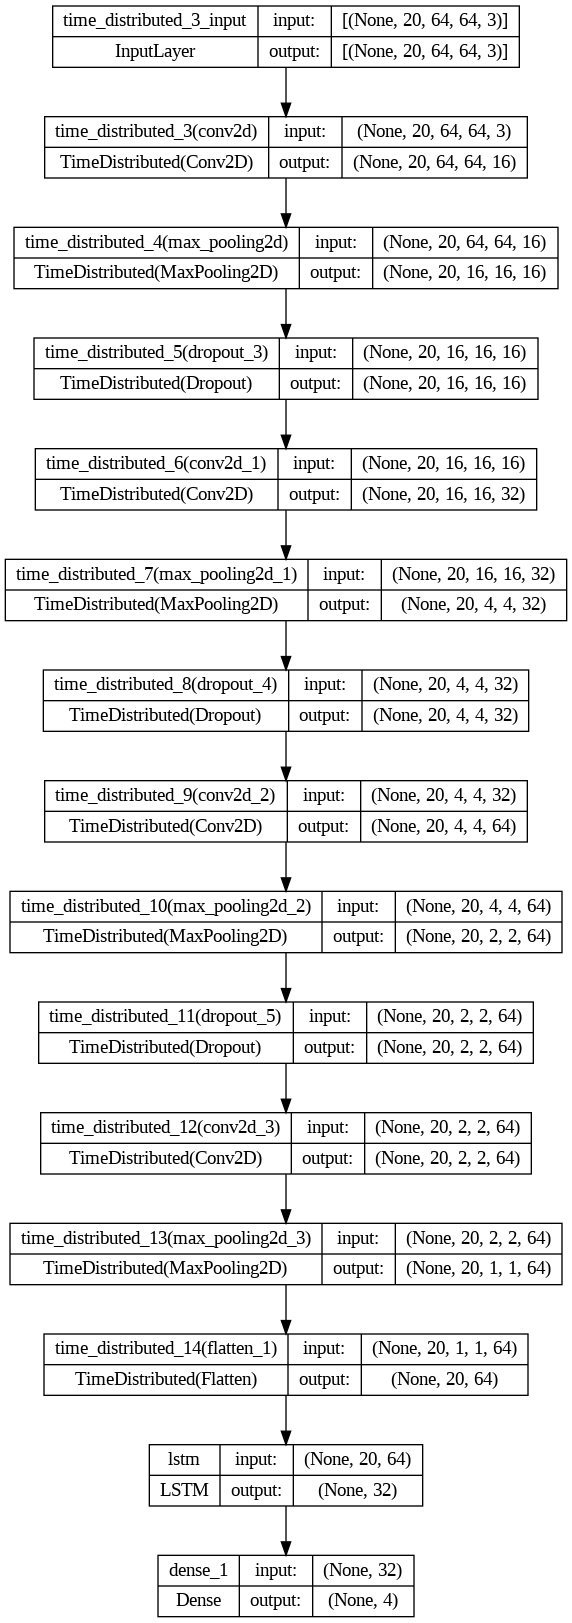

In [ ]:
plot_model(lrcn_model, to_file='LRCN_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
early_stopping_callback=EarlyStopping(monitor='val_loss', patience=15, mode='min', restore_best_weights=True)
lrcn_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
lrcn_model_hist=lrcn_model.fit(x=features_train, y=labels_train, epochs=70, batch_size=4, shuffle=True, validation_split=0.2, callbacks=[early_stopping_callback])

Epoch 1/70
73/73 [==============================] - 20s 228ms/step - loss: 1.3902 - accuracy: 0.2911 - val_loss: 1.3818 - val_accuracy: 0.1918
Epoch 2/70
73/73 [==============================] - 16s 214ms/step - loss: 1.3403 - accuracy: 0.3870 - val_loss: 1.4032 - val_accuracy: 0.1781
Epoch 3/70
73/73 [==============================] - 18s 247ms/step - loss: 1.2857 - accuracy: 0.4315 - val_loss: 1.3164 - val_accuracy: 0.3699
Epoch 4/70
73/73 [==============================] - 16s 218ms/step - loss: 1.2006 - accuracy: 0.4726 - val_loss: 1.3572 - val_accuracy: 0.2877
Epoch 5/70
73/73 [==============================] - 16s 217ms/step - loss: 1.0754 - accuracy: 0.5377 - val_loss: 0.9722 - val_accuracy: 0.5616
Epoch 6/70
73/73 [==============================] - 16s 215ms/step - loss: 0.9644 - accuracy: 0.6267 - val_loss: 1.0107 - val_accuracy: 0.6027
Epoch 7/70
73/73 [==============================] - 20s 268ms/step - loss: 0.9039 - accuracy: 0.6336 - val_loss: 1.0629 - val_accuracy: 0.6438

In [ ]:
model_evaluation_history=lrcn_model.evaluate(features_test, labels_test)

4/4 [==============================] - 2s 565ms/step - loss: 0.3269 - accuracy: 0.9098


In [ ]:
# accuracy and loss
model_evaluation_loss, model_evaluation_accuracy=model_evaluation_history
date_time_format='%Y_%m_%d_%H_%M_%S'
current_date_time_dt=dt.datetime.now()
current_date_time_string=dt.datetime.strftime(current_date_time_dt, date_time_format)
model_file_name=f'convlstm_model__Date_Time{current_date_time_string}__Loss{model_evaluation_loss}__Accuracy_{model_evaluation_accuracy}.h5'
lrcn_model.save(model_file_name)

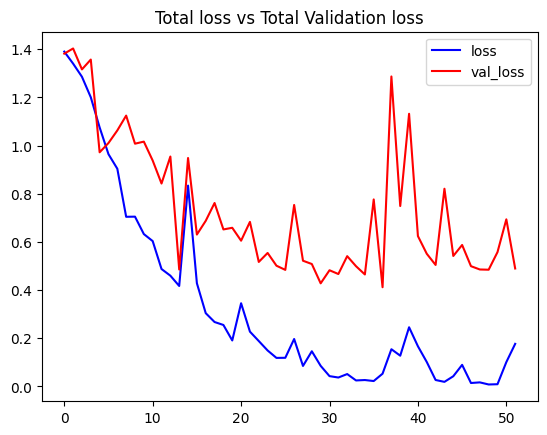

In [ ]:
plot_metric(lrcn_model_hist, 'loss', 'val_loss', 'Total loss vs Total Validation loss')

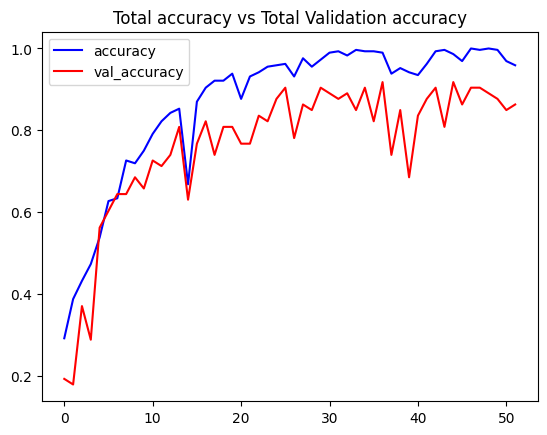

In [ ]:
plot_metric(lrcn_model_hist, 'accuracy', 'val_accuracy', 'Total accuracy vs Total Validation accuracy')

< cv2.VideoCapture 0x7f6f26251350>
TrampolineJumping


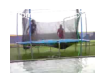

In [ ]:
all_classes_names=os.listdir('UCF50')
random_range=random.sample(range(len(all_classes_names)), 1)

for counter, random_index in enumerate(random_range, 1):
  selected_class_name=all_classes_names[random_index]
  video_files_names_list=os.listdir(f'UCF50/{selected_class_name}')
  selected_video_file_name=random.choice(video_files_names_list)
  video_reader=cv2.VideoCapture(f'UCF50/{selected_class_name}/{selected_video_file_name}')
  _, bgr_frame=video_reader.read()
  video_reader.release()
  rgb_frame=cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
  cv2.putText(rgb_frame, selected_class_name, (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
  plt.subplot(5,4,counter);plt.imshow(rgb_frame);plt.axis('off')
print(video_reader)
print(selected_class_name)